# Drift-diffusion simulation of electrochemical doping

This notebook reproduces simulations of electrochemical doping from Eleni Stavrinidou, Pierre Leleux, Harizo Rajaona, Michel Fiocchi, Sébastien Sanaur, George G. Malliaras [A simple model for ion injection and transport in conducting polymers](http://dx.doi.org/10.1063/1.4812236), Journal of Applied Physics 113, 244501 (2013).

Note that all profiles of electric potential in the paper are inverted, and contradicting Fig. 1 shown within. 

The model is multilayer, multispecies. The simulation may not work for longer times than investigated in the paper because of formation of EDL which is poorly handled without further assumptions.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pylab as plt

from oedes import *

In [3]:
electrolyte_mesh = fvm.mesh1d(
    25e-9,
    boundary_names=[
        'electrode',
        'internal_boundary'])
pedot_mesh = fvm.mesh1d(
    175e-9,
    boundary_names=[
        'internal_boundary',
        'electrode'])
mesh = fvm.multilayer1d(
    [('electrolyte', electrolyte_mesh), ('pedot', pedot_mesh)])
electrolyte_model = models.BaseModel()
electrolyte_model.name = 'electrolyte'
pedot_model = models.BaseModel()
pedot_model.name = 'pedot'
poisson_electrolyte = fvm.Poisson(electrolyte_mesh)
electrolyte_model.poisson = poisson_electrolyte
poisson_pedot = fvm.Poisson(pedot_mesh)
pedot_model.poisson = poisson_pedot
poisson_electrolyte.bc = [
    models.AppliedVoltage('electrode'),
    models.Equal(
        poisson_pedot,
        'internal_boundary')]
poisson_pedot.bc = [models.AppliedVoltage('electrode')]
hole_eqn = fvm.TransportCharged(pedot_mesh, 'hole', z=1)
hole_eqn.bc = [models.DirichletFromParams('electrode')]
cation_electrolyte = fvm.TransportCharged(electrolyte_mesh, 'cation', z=1)
cation_electrolyte.bc = [models.DirichletFromParams('electrode')]
anion_electrolyte = fvm.TransportCharged(electrolyte_mesh, 'anion', z=-1)
anion_electrolyte.bc = [models.DirichletFromParams('electrode')]
electrolyte_model.species = [cation_electrolyte, anion_electrolyte]
electrolyte_model.species_v_D['cation'] = models.species_v_D_charged_from_params
electrolyte_model.species_v_D['anion'] = models.species_v_D_charged_from_params
cation_pedot = fvm.TransportCharged(pedot_mesh, 'cation', z=1)
cation_pedot.bc = [models.Equal(cation_electrolyte, 'internal_boundary')]
anion_pedot = fvm.TransportCharged(pedot_mesh, 'anion', z=-1)
anion_pedot.bc = [models.Equal(anion_electrolyte, 'internal_boundary')]
pedot_model.species = [hole_eqn, cation_pedot, anion_pedot]
pedot_model.species_v_D['hole'] = models.species_v_D_charged_from_params
pedot_model.species_v_D['cation'] = models.species_v_D_charged_from_params
pedot_model.species_v_D['anion'] = models.species_v_D_charged_from_params
pedot_model.additional_charge = [models.simple_doping]
model = models.CompositeModel()
model.sub = [electrolyte_model, pedot_model]
model.setUp()

In [4]:
params = {
    'electrolyte.epsilon_r': 3.,
    'pedot.epsilon_r': 3,
    'electrolyte.T': 300,
    'pedot.T': 300,
    'electrolyte.electrode.voltage': 0,
    'electrolyte.electrode.workfunction': 0,
    'pedot.electrode.voltage': 0,
    'pedot.electrode.workfunction': 0,
    'pedot.hole.N0': 1e27,
    'pedot.hole.electrode': 1e25,
    'pedot.hole.mu': 1e-7,
    'pedot.hole.level': 0,
    'pedot.Na': 1e25,
    'pedot.Nd': 0,
    'electrolyte.cation.electrode': 1e25,
    'electrolyte.cation.mu': 1e-7,
    'electrolyte.cation.N0': 1e27,
    'electrolyte.cation.level': 0.,
    'electrolyte.anion.electrode': 1e25,
    'electrolyte.anion.mu': 1e-7,
    'electrolyte.anion.N0': 1e27,
    'electrolyte.anion.level': 0.,
    'pedot.cation.mu': 1e-9,
    'pedot.cation.N0': 1e27,
    'pedot.cation.level': 0.,
    'pedot.anion.mu': 1e-9,
    'pedot.anion.N0': 1e27,
    'pedot.anion.level': 0.
}

In [5]:
def store(out):
    testing.store(out['electrolyte.potential'])
    testing.store(out['electrolyte.anion.c'], atol=1e12)
    testing.store(out['electrolyte.cation.c'], atol=1e12)
    testing.store(out['pedot.potential'], atol=1e12)
    testing.store(out['pedot.hole.c'], atol=1e12)
    testing.store(out['pedot.anion.c'], atol=1e12)
    testing.store(out['pedot.cation.c'], atol=1e12)

## Fig. 2

In [6]:
x = model.X.copy()
x[hole_eqn.idx] = params['pedot.Na']
c = context(model, x=x)
params['electrolyte.electrode.voltage'] = 0.
params['pedot.electrode.voltage'] = -1
c.transient(params, 1e-5, 1e-9)

 time=1e-05            

In [7]:
from oedes import mpl

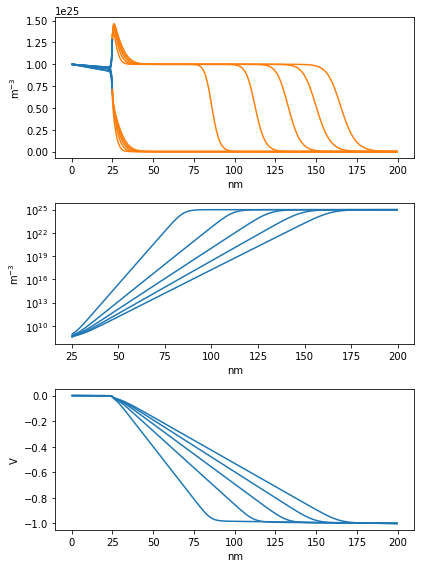

In [8]:
fig, (ion_plot, hole_plot, potential_plot) = plt.subplots(
    nrows=3, figsize=(6, 8))
for time in [2e-6, 4e-6, 6e-6, 8e-6, 10e-6]:
    ts = c.attime(time)
    store(ts.output())
    ts.mpl(fig, ion_plot).species('cation', settings=mpl.Settings.c_x_nm)
    ts.mpl(fig, ion_plot).species('anion', settings=mpl.Settings.c_x_nm)
    o = ts.output()
    ts.mpl(fig, hole_plot).species('hole')
    ts.mpl(fig, potential_plot).potential()
fig.tight_layout()

## Fig. 3

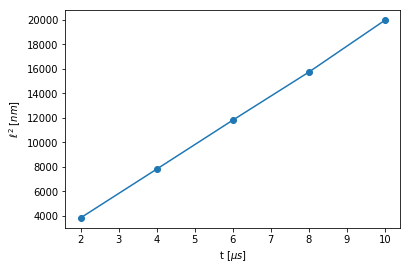

In [9]:
def length(out):
    store(out)
    c = out['pedot.hole.c']
    i = np.argwhere(c > 0.5e25)[0]
    return pedot_mesh.cells['center'][i] - pedot_mesh.cells['center'][0]


times = np.asarray([2e-6, 4e-6, 6e-6, 8e-6, 10e-6])
plt.plot(times * 1e6, [length(c.attime(t).output())
                       ** 2 * 1e18 for t in times], '-o')
plt.xlabel('t [$\mu s$]')
plt.ylabel('$\ell^2$ [$nm%2$]')

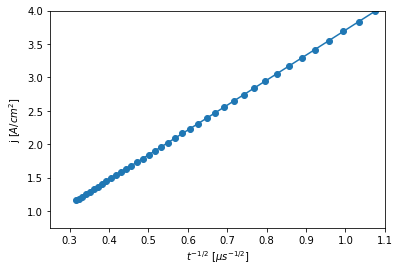

In [10]:
t, j = c.teval('time', 'pedot.J')
t, j = t[t > 0], j[t > 0]
plt.plot(1. / np.sqrt(t * 1e6), j * 1e-4, 'o-')
plt.xlim([0.25, 1.1])
plt.ylim([0.75, 4])
plt.xlabel('$t^{-1/2}$ [$\mu s^{-1/2}$]')
plt.ylabel('j [$A/cm^2$]')

## Fig. 4

In [11]:
x0 = model.X.copy()
x0[hole_eqn.idx] = params['pedot.Na']
by_v = {}
voltages = [0.01, 0.05, 0.1, 0.5, 1]
for v in voltages:
    params['pedot.electrode.voltage'] = -v
    c = context(model, x=x0)
    c.transient(params, 1e-5, 1e-9)
    by_v[v] = c

 time=1e-05            

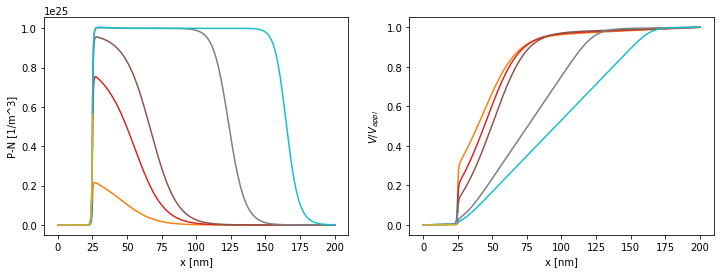

In [12]:
fig, (ion_plot, potential_plot) = plt.subplots(ncols=2, figsize=(12, 4))
for v in voltages:
    o = by_v[v].attime(1e-5).output()
    store(o)
    ion_plot.plot(
        electrolyte_mesh.cells['center'] *
        1e9,
        o['electrolyte.cation.c'] -
        o['electrolyte.anion.c'])
    ion_plot.plot(
        pedot_mesh.cells['center'] *
        1e9,
        o['pedot.cation.c'] -
        o['pedot.anion.c'])
    ion_plot.set_xlabel('x [nm]')
    ion_plot.set_ylabel('P-N [1/m^3]')
    potential_plot.plot(
        electrolyte_mesh.cells['center'] * 1e9, o['electrolyte.potential'] / (-v))
    potential_plot.plot(
        pedot_mesh.cells['center'] * 1e9, o['pedot.potential'] / (-v))
    potential_plot.set_xlabel('x [nm]')
    potential_plot.set_ylabel('$V/V_{appl}$')

## Fig. 5

In [13]:
x0 = model.X.copy()
x0[hole_eqn.idx] = params['pedot.Na']
params['pedot.electrode.voltage'] = -1.
concentrations = [1e24, 1e25, 1e26]
by_c = {}
for conc in concentrations:
    params['electrolyte.cation.electrode'] = conc
    params['electrolyte.anion.electrode'] = conc
    c = context(model, x=x0)
    c.transient(params, 1e-5, 1e-9)
    by_c[conc] = c

 time=1e-05            

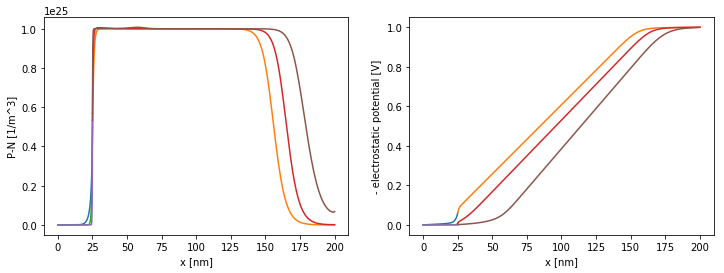

In [14]:
fig, (ion_plot, potential_plot) = plt.subplots(ncols=2, figsize=(12, 4))
for conc in concentrations:
    o = by_c[conc].attime(1e-5).output()
    store(o)
    ion_plot.plot(
        electrolyte_mesh.cells['center'] *
        1e9,
        o['electrolyte.cation.c'] -
        o['electrolyte.anion.c'])
    ion_plot.plot(
        pedot_mesh.cells['center'] *
        1e9,
        o['pedot.cation.c'] -
        o['pedot.anion.c'])
    ion_plot.set_xlabel('x [nm]')
    ion_plot.set_ylabel('P-N [1/m^3]')
    potential_plot.plot(
        electrolyte_mesh.cells['center'] * 1e9, -o['electrolyte.potential'])
    potential_plot.plot(
        pedot_mesh.cells['center'] * 1e9, -o['pedot.potential'])
    potential_plot.set_xlabel('x [nm]')
    potential_plot.set_ylabel('- electrostatic potential [V]')

## Fig. 6

In [15]:
x0 = model.X.copy()
x0[hole_eqn.idx] = params['pedot.Na']
params['pedot.electrode.voltage'] = -1.
params['electrolyte.cation.electrode'] = 1e25
params['electrolyte.anion.electrode'] = 1e25
mu_values = [1e-10, 1e-9, 1e-8]
by_mu = {}
for mu in mu_values:
    params['pedot.cation.mu'] = mu
    params['pedot.anion.mu'] = mu
    c = context(model, x=x0)
    c.transient(params, 1e-5, 1e-9)
    by_mu[mu] = c

 time=1e-05            

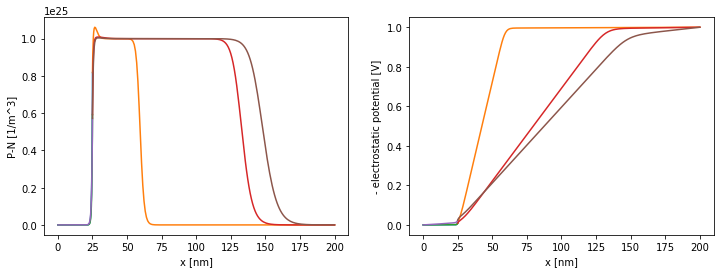

In [16]:
fig, (ion_plot, potential_plot) = plt.subplots(ncols=2, figsize=(12, 4))
time = {1e-10: 6e-6, 1e-9: 6e-6, 1e-8: 1e-6}
for mu in mu_values:
    o = by_mu[mu].attime(time[mu]).output()
    store(o)
    ion_plot.plot(
        electrolyte_mesh.cells['center'] *
        1e9,
        o['electrolyte.cation.c'] -
        o['electrolyte.anion.c'])
    ion_plot.plot(
        pedot_mesh.cells['center'] *
        1e9,
        o['pedot.cation.c'] -
        o['pedot.anion.c'])
    ion_plot.set_xlabel('x [nm]')
    ion_plot.set_ylabel('P-N [1/m^3]')
    potential_plot.plot(
        electrolyte_mesh.cells['center'] * 1e9, -o['electrolyte.potential'] / v)
    potential_plot.plot(
        pedot_mesh.cells['center'] * 1e9, -o['pedot.potential'] / v)
    potential_plot.set_xlabel('x [nm]')
    potential_plot.set_ylabel('- electrostatic potential [V]')


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
